# CLIP From Scratch (Vague Implementation During Exam) Do not use it

# INTRODUCTION
I have implemented this code in refrence with Google Colab, as it gives me really good flexiblity to debug the code, and make it reprodubable every time, just one click and it always work, I have implemented CLIP Model, The Attention Class (Logic) will be comon for Text and Vision Transformer and then Text and Vision Transformer will be combined to form a complete model CLIP MODEL

```sh
ATTENTION CLASS
    |
TEXT TRANSFORMER & VISION TRANSFORMER
    |
CLIP MODEL
```

- It has 2 Transformer Blocks
- It has 4 heads
- it can also perform causual and non-causal attention

I have also plotted the loss and accuracy for both text and vision transformer
And their learn space embeddings

**NOTE: THIS CODE WAS WRITTEN AND OPTIMIZED IN DOCKER CONTAINER AND WAS TRAINED ON GOOGLE COLAB, SO THERE ARE SOME PATHS STARTING WITH /app/exam**

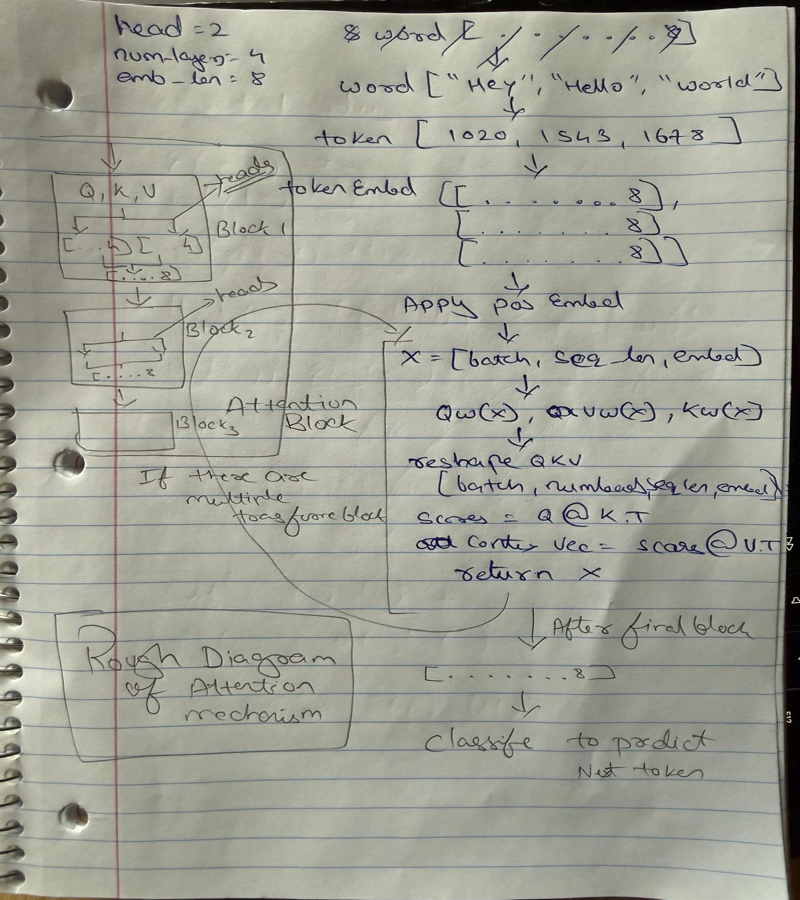

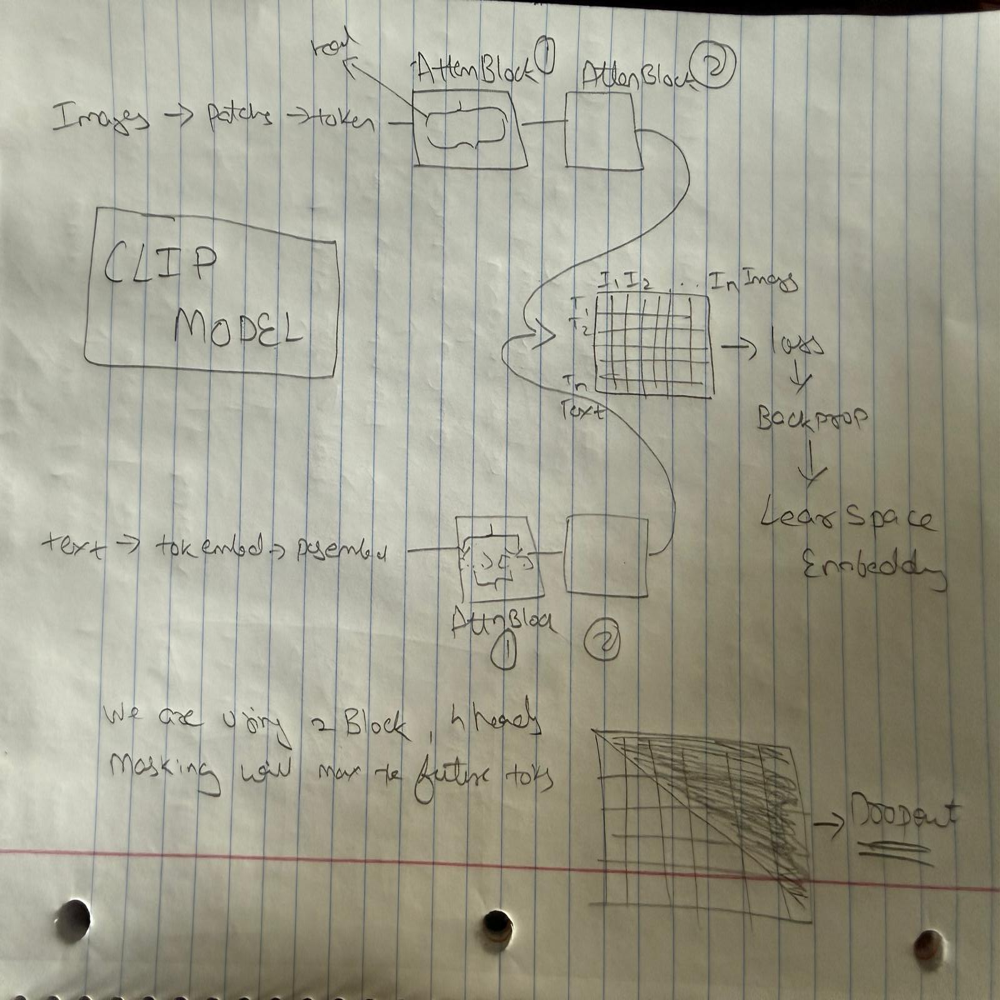

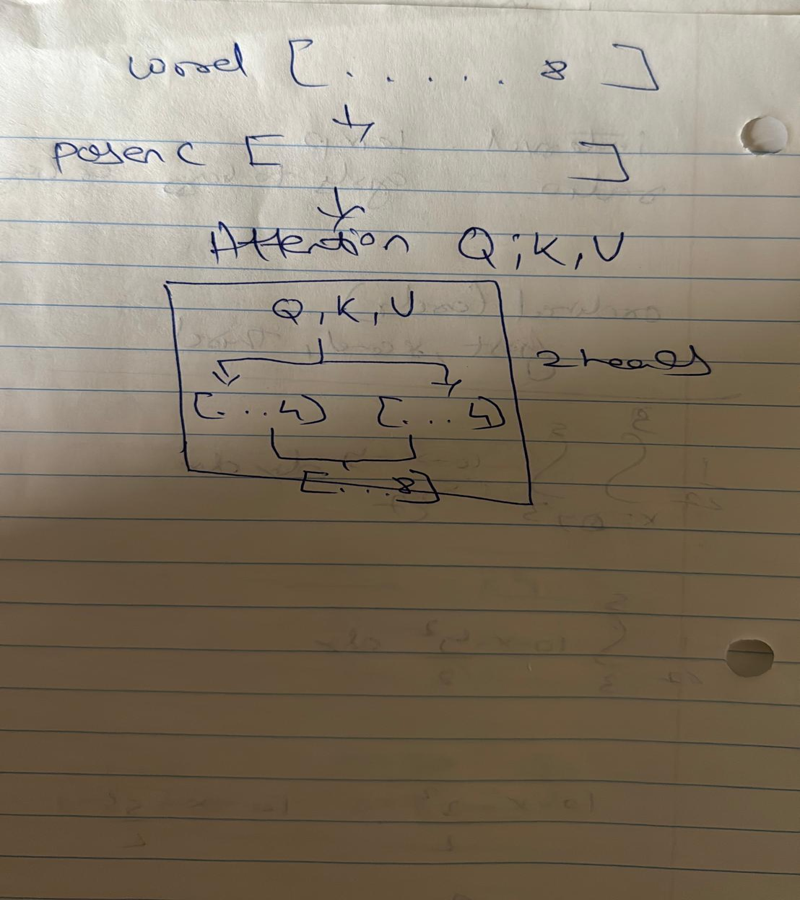

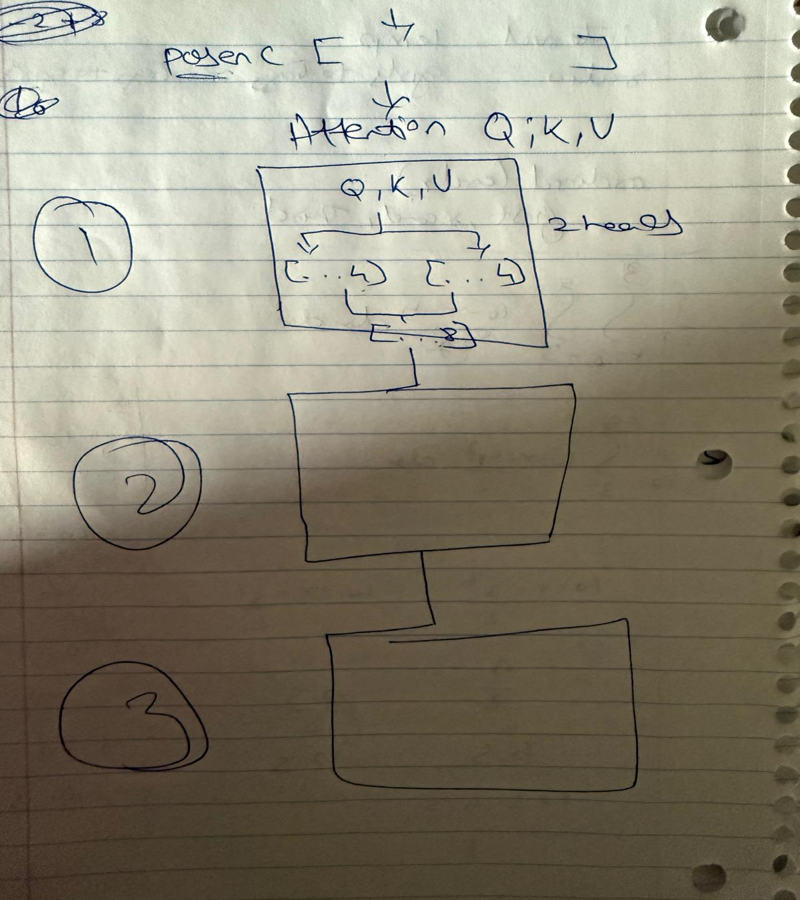

In [1]:
from PIL import Image

img = Image.open('/app/exam/notes/ATTNETION_MECH.jpeg')
img_resized = img.resize((800, 900))
display(img_resized)


img = Image.open('/app/exam/notes/CLIP MODEL.jpeg')
img_resized = img.resize((1000, 1000))
img_resized = img_resized.rotate(90)
display(img_resized)


img = Image.open('/app/exam/notes/One_BLOCK_WITH_HEAD.jpeg')
img_resized = img.resize((800, 900))

display(img_resized)


img = Image.open('/app/exam/notes/TransformerBlocks.jpeg')
img_resized = img.resize((800, 900))
display(img_resized)

In [2]:
# Importing all the necessary packages
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from dataclasses import dataclass
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
from typing import List
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import os
import kagglehub
import json
from PIL import Image
from pathlib import Path


In [3]:

# AS i am not using tesla server i am downloading the dataset from kagglehub
os.environ['DISABLE_COLAB_CACHE'] = "true"
os.environ['KAGGLEHUB_CACHE'] = '/content/data'


# so the path information will be stored here and will be used later on in the config file
path = kagglehub.dataset_download("ambityga/imagenet100")
print("Path to dataset files:", path)


# Test Paht of mini sample
# path = "/content/data/mini_sample/datasets/ambityga/imagenet100/versions/8"

100%|██████████| 16.1G/16.1G [03:38<00:00, 79.1MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/ambityga/imagenet100/versions/8


In [4]:
# this genrates the config for the Architure, like how many heads we are using,
# how many transformer blocks(num_layers) we need, etc ...
@dataclass
class CLIPConfig():
    embed_dim = 512
    num_heads = 4
    num_layers = 2
    dropout = 0.2
    vocab_size = 49408

    image_embed_dim = 512
    image_size = 224
    patch_size = 16
    vision_num_heads = 4
    vision_num_layers = 2
    vision_dropout =  0.2


config = CLIPConfig()


In [5]:
class Attention(nn.Module):
    """
    This class is common for both TextTransformer and VisionTransformer

    Attention class contains the main implementation for the attention mechanism, attention heads, causal masking, etc...
    """

    def __init__(self,num_heads,embed_dim,dropout=0.2,use_causal_mask=False):
        super().__init__()
        self.use_causal_mask = use_causal_mask
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_embed_dim = embed_dim // num_heads
        self.scale = 1.0 / math.sqrt(self.head_embed_dim)
        self.dropout = dropout
        self.ffn_layer = nn.Sequential(
            nn.Linear(self.embed_dim,self.embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(self.embed_dim * 4,self.embed_dim),
            nn.Dropout(dropout)
        )

        self.norm1 = nn.LayerNorm(self.embed_dim)
        self.norm2 = nn.LayerNorm(self.embed_dim)

        if embed_dim % num_heads != 0:
            raise ValueError("num_heads should be divisible by embed dim")



        self.QW = nn.Linear(self.embed_dim,self.embed_dim)
        self.KW = nn.Linear(self.embed_dim,self.embed_dim)
        self.VW = nn.Linear(self.embed_dim,self.embed_dim)

    def forward(self,x):
        batch_size, seq_length, embed_dim = x.shape

        # fist all the values will be passed in the linearl Layer of Q, K, V independently
        # x -> [batch_size, seq_length, embed_dim]
        Q = self.QW(x)
        K = self.KW(x)
        V = self.VW(x)

        residual = x

        def reshape(self,x):
            """
                to implement number of heads we will reshape the x i have mention flow below

                FLOW:
                [batch_seq, seq_len,embed_dim] -> [batch_seq, seq_len,num_heads,head_embed_dim] ->
                -> [batch_seq,num_heads,seq_len,head_embed_dim]

                SIDE NOTE:
                Image Data will already be flatten so we dont have to implemnt any specific logic for image data
            """
            batch_size, seq_len, embed_dim = x.shape
            x = x.view(batch_size, seq_len, self.num_heads,self.head_embed_dim)
            x = x.transpose(1,2)
            return x

        Q = reshape(self,Q)
        K = reshape(self,K)
        V = reshape(self,V)

        # so here the data Q, K, V will be [batch_size, num_heads, seq_length, head_embed_dim]
        # scores contains the main attent_weights
        # Matrix Mul between Q @ K.T, will assign score to each token, how much attention to give to each token
        scores = torch.matmul(Q,K.transpose(-2,-1)) * self.scale
        seq_len = scores.size(-1)
        if self.use_causal_mask:
            # for text data we will use causal mask, it will not see future tokens
            causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
            scores = scores.masked_fill(causal_mask, float('-inf'))

        # so softmax is basically a normalization function
        scores = torch.softmax(scores,dim=-1)

        # so dropout is used to prevent overfitting, it will drop some of the values in our case it will drop 0.2% of the batch
        scores = torch.dropout(scores,p=self.dropout,train=self.training)

        # so this is final main logic to generate the context_vector,
        # which will be used to generate the output and later which will be passed in the norm layers
        # so as per my understanding this will create one embeding seq which will be used to predict the next token at the feed forward layer (which will work as classifire) at the end
        context_vec = torch.matmul(scores,V)
        context_vec = context_vec.transpose(1,2).contiguous()
        context_vec = context_vec.view(batch_size,seq_length,embed_dim)
        # context_vec_out = self.ffn_layer(context_vec)

        # for attention sublayer
        x = self.norm1(residual + context_vec)

        # for resudial sublayer
        x = self.norm2(x + self.ffn_layer(x))

        return x

"""
tensor([[[ 0.4274, -0.5666, -0.1543,  ..., -0.9187, -1.5763, -0.5108],
         [-1.3496,  1.6104, -1.5188,  ..., -0.5628,  0.2320, -0.2716],
         [ 0.2344,  1.0088,  1.2953,  ...,  0.0422,  0.2786,  0.8906],
         [ 0.1044,  0.2361,  0.3475,  ..., -0.8331,  1.7534,  0.8875]],

        [[-0.1956, -0.6549, -1.2990,  ...,  0.3106, -1.0145,  0.3250],
         [-1.7180, -0.1407,  0.5195,  ..., -1.1922, -0.3939, -0.7297],
         [ 0.3847,  0.2957, -0.4784,  ...,  1.9734,  0.8213, -0.4533],
         [-0.1636,  0.7975,  0.2403,  ...,  1.8992, -0.6989,  0.6359]]],
       grad_fn=<NativeLayerNormBackward0>)

The X variable will look something like this, and will will take out last token and feed it into an classfire of token which will predict the next token
"""


# Testing
x = torch.randn(2,4,CLIPConfig.embed_dim) # <- batch_size, seq_len, embed_dim
model  = Attention(num_heads=CLIPConfig.num_heads,embed_dim=CLIPConfig.embed_dim)
model(x)

tensor([[[-1.2137,  2.4175, -0.4400,  ..., -2.0144,  0.5635,  1.0213],
         [ 0.4920, -0.6255, -1.5334,  ..., -2.4388,  0.7516, -3.4821],
         [-0.1539,  1.3132,  1.1078,  ..., -0.8747, -0.8965,  0.1212],
         [ 0.6326,  0.0845, -0.0159,  ..., -0.4886,  0.2868, -0.9945]],

        [[-0.0071, -0.7130, -0.7300,  ..., -0.2283,  1.4579, -1.0420],
         [ 0.2184, -0.6228,  0.5561,  ...,  0.6840, -0.4832, -0.6840],
         [-0.3331,  1.2629, -0.8979,  ..., -1.5335, -0.2715,  0.1129],
         [-0.9540, -0.0066,  1.1429,  ...,  1.2848, -0.3252, -1.6156]]],
       grad_fn=<NativeLayerNormBackward0>)

In [6]:
class TextTransformer(nn.Module):
    def __init__(self,config:CLIPConfig,verbose=False):
        super().__init__()
        self.config = config

        ## This is Basically Transformer Block, like how many times the x value is passed into an Attention Mechanism, so basically it helps to understad the context of the word ,
        ## and also the learn Space Embeddings
        self.layers = nn.ModuleList([
            Attention(num_heads=self.config.num_heads,embed_dim=self.config.embed_dim,dropout=self.config.dropout,use_causal_mask=False)
            for _ in range(self.config.num_layers)
        ])
        self.verbose = verbose
        self.final_norm = nn.LayerNorm(self.config.embed_dim)

        # this layer converts words into tokens
        self.token_embeddings = nn.Embedding(self.config.vocab_size,self.config.embed_dim)

        # this add the position encoding to the tokens, it is not ROPE (Rotary Positional Encoding) it is just positional encoding
        self.pos_embeddings = nn.Embedding(77,self.config.embed_dim)
        self.text_projection = nn.Linear(config.embed_dim, config.embed_dim)



    def forward(self,x):

        batch, seq_len = x.shape

        # Generate the token embeddings
        x = self.token_embeddings(x)
        pos = torch.arange(seq_len,device=x.device)
        # Add postion encoding to the token embeddings
        pos_emb = self.pos_embeddings(pos)
        x = x + pos_emb

        # in here the x value is passed into the attention mechanism, in every transformer block the x value is updated after returning
        # from every block and passed that same values to the next block to learn space embeddings
        for layer_idx, layer in enumerate(self.layers):
            x = layer(x)
            if self.verbose:
                print(layer_idx)
                print(layer)
                print(x)
                print("=" * 80)

        x = x[:, -1, :]  # Extract [EOS] token (last position)
        x = self.text_projection(x)
        x = F.normalize(x, p=2, dim=-1)

        return x


"""
INPUT X:
tensor([[41496, 38247,  9845,  1899],
        [47806, 29628, 27762, 33305]])

        so it has 2 batches and 4 tokens in each batch, so 8 tokens in total after attnetion
        we will take the last token from each batch in this example 1899 from the first batch and 33305 from the second batch

The X will return something like this and it contains the last token embedding of both the batches, basically an embedings to preict the next toke in the clasifire
tensor([[ 0.0274,  0.0185,  0.0254,  ...,  0.0216,  0.0314,  0.0147],
        [-0.0003, -0.0155,  0.0286,  ...,  0.0214, -0.0261, -0.1019]],
       grad_fn=<DivBackward0>)
"""


# Test
x = torch.randint(
    low=0,
    high=config.vocab_size,  # Token IDs must be < vocab_size
    size=(2, 4)  # [batch_size, seq_len] - NO embed_dim here!
).long()  # Ensure it's LongTensor
print(x)
model = TextTransformer(config=config,verbose=False)
x = model(x)
print(x)

tensor([[ 7519, 13872, 11587, 21703],
        [ 7875, 14288,   214, 23362]])
tensor([[ 0.0003, -0.0157, -0.0850,  ..., -0.0320,  0.0027, -0.0154],
        [-0.0665,  0.0503,  0.0023,  ..., -0.0350, -0.0232,  0.0262]],
       grad_fn=<DivBackward0>)


In [7]:
# NOW working on images, Most of the code will be similar to the text embeddings
class VisionTransformer(nn.Module):
    def __init__(self,config:CLIPConfig,verbose=False):
        super().__init__()

        self.verbose = verbose
        self.config = config

        # we will convert the image to patches
        self.num_patches = (config.image_size // config.patch_size) ** 2

        # we will project the image to the image embed dimension
        self.proj = nn.Conv2d(in_channels=3,out_channels=config.image_embed_dim,kernel_size=config.patch_size,stride=config.patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1,1,config.image_embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,self.num_patches + 1,config.image_embed_dim))

        # Number of Transformer Blocks we are applying
        self.layers = nn.ModuleList([
            Attention(num_heads=config.vision_num_heads,embed_dim=config.image_embed_dim,dropout=config.vision_dropout)
            for _ in range(self.config.vision_num_layers)
        ])


        self.norm = nn.LayerNorm(config.image_embed_dim)
        self.head = nn.Linear(config.image_embed_dim,config.embed_dim)

    def forward(self,x):
        batch_size = x.shape[0]
        x = self.proj(x)
        # this is the most unique step in the vision trasformer, we will flattent those pattches into a single vector, basically a single dim just like text embeddings
        x = x.flatten(2).transpose(1,2)
        cls_tokens = self.cls_token.expand(batch_size,-1,-1)
        x = torch.cat([cls_tokens,x],dim=1)

        x = x + self.pos_embed
        # print("x Shape",x.shape)

        for layer_idx,layer in enumerate(self.layers):
            # print(layer_idx,layer)
            x = layer(x)
            if self.verbose:
                print(layer_idx)
                print(layer)
                print(x)
                print("=" * 80)



        x = self.norm(x)
        x = x[:,0]

        x = self.head(x)
        x = F.normalize(x,p=2,dim=-1)

        return x

"""
INPUT:
tensor([[[[-1.2265,  0.7315, -0.4907,  ..., -0.6520, -1.5252, -1.3551],
          [-1.3708,  1.2608,  1.2234,  ..., -0.5925, -0.9221,  0.2545],
          [-1.6404,  0.5248, -0.3282,  ..., -0.6585,  1.3908,  1.6163],
          ...,
          [ 0.8519,  0.8679, -0.7479,  ..., -0.5135, -0.7725,  1.4982],
          [ 2.5473,  1.2031,  0.2235,  ...,  0.0454, -0.3829,  1.7460],
          [-1.0496,  0.4143, -0.2643,  ...,  0.1379, -0.4247, -0.5341]],

         [[-0.2502,  1.8147,  0.8538,  ...,  0.0192, -0.9816,  0.2728],
          [ 0.6577, -0.5976, -0.6775,  ...,  0.4512,  0.3158,  0.1578],
          [-0.3026,  0.1163,  1.2664,  ...,  0.1066, -0.3898, -0.7039],
          ...,
          [ 0.0256, -1.1441,  1.4676,  ..., -0.3191, -0.0228, -0.5473],
          [ 0.3596,  0.1072, -0.9292,  ...,  0.5137,  1.0511,  0.9557],
          [ 1.1943,  0.3947, -0.3326,  ...,  1.5259, -0.5456,  1.2366]],

         [[ 1.0110,  0.1986, -1.3472,  ...,  0.8286,  1.4451,  0.0118],
          [ 0.0207,  0.9297,  0.2487,  ...,  0.2223, -0.3658, -0.6485],
          [ 1.5924,  0.2292,  0.4428,  ..., -0.8075,  0.0819, -0.5970],
          ...,
          [-0.1518, -0.6618, -0.3255,  ..., -0.0785,  0.8505,  0.1646],
          [ 0.9533,  0.6493, -0.1343,  ...,  1.6862, -2.3321,  0.1534],
          [-0.5240,  1.0629, -0.9944,  ...,  1.2993,  1.3328,  1.0592]]],

...
          [-1.5878,  0.4079, -0.4992,  ...,  0.1335, -0.1514, -1.1365]]]])

return x (after processing)
tensor([[-0.0188,  0.0633, -0.0563,  ...,  0.0447,  0.0461,  0.0818],
        [ 0.0091,  0.0239, -0.0560,  ...,  0.0390,  0.0455,  0.0656]],
       grad_fn=<DivBackward0>)
"""

# test
model = VisionTransformer(config=config,verbose=False)
x = torch.randn(2, 3, config.image_size, config.image_size)
print(x)
x = model(x)
print(x)

tensor([[[[ 1.9713,  0.5362,  0.1668,  ...,  0.6685,  0.9001,  2.3009],
          [-0.4911, -0.9677,  0.4108,  ..., -1.3992,  1.0596, -0.3026],
          [-0.6543, -1.0802,  0.3798,  ..., -2.1636, -0.3384,  0.6845],
          ...,
          [ 1.6254, -0.0654, -1.5484,  ...,  0.1158, -1.2286, -0.2755],
          [ 0.0800,  0.1267, -1.5352,  ...,  0.4790, -0.0697, -2.3479],
          [-0.0600,  0.4395, -2.0842,  ...,  0.1441,  1.0657,  1.5123]],

         [[ 0.5547, -0.5555,  0.8323,  ...,  1.4163, -1.0805,  0.7848],
          [-1.0678,  0.4002, -0.1920,  ...,  0.1253,  0.8526, -0.5169],
          [-1.0348, -1.8264, -0.0760,  ..., -0.7836, -0.9326,  0.1257],
          ...,
          [ 0.2297,  0.4296, -0.0548,  ..., -0.3531,  0.6583, -0.8668],
          [ 0.0066, -1.4207,  0.7682,  ...,  0.2200, -0.1596, -1.2672],
          [ 0.2733,  0.5799,  1.3110,  ...,  0.5035,  0.0389,  0.6063]],

         [[-1.2936, -1.1322, -0.9636,  ...,  1.9884,  1.7385,  0.1656],
          [ 0.3672,  0.2997,  

In [8]:
def clip_loss(logits_per_image, logits_per_text):
    """
    Symmetric contrastive loss for CLIP

    Args:
        logits_per_image: [batch_size, batch_size] similarity matrix
        logits_per_text: [batch_size, batch_size] similarity matrix

    Returns:
        loss: scalar tensor
    """
    batch_size = logits_per_image.shape[0]

    # Ground truth
    labels = torch.arange(batch_size, device=logits_per_image.device)

    # Image-to-text cross-entropy loss
    loss_i = F.cross_entropy(logits_per_image, labels)

    # Text-to-image cross-entropy loss
    loss_t = F.cross_entropy(logits_per_text, labels)

    # Symmetric loss (average of both directions)
    loss = (loss_i + loss_t) / 2

    return loss


In [9]:
class CLIP(nn.Module):
    """
    Unifies both the text and the vision encoders into a single model.
    """
    def __init__(self, config:CLIPConfig):
        super().__init__()
        self.text_encoder = TextTransformer(config=config, verbose=False)
        self.vision_encoder = VisionTransformer(config=config, verbose=False)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.07))

    def forward(self, images, text):
        image_features = self.vision_encoder(images)
        text_features = self.text_encoder(text)
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.T
        logits_per_text = logits_per_image.T
        return logits_per_image, logits_per_text

    def get_embeddings(self, images, text):
        """
        Returns image and text embeddings **BEFORE** normalization for loss purposes.
        """
        image_features = self.vision_encoder(images)
        text_features = self.text_encoder(text)
        # Normalize to unit length (very important for contrastive training and visualization!)
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        return image_features, text_features


# Training Data

In [10]:
@dataclass
class ImageNet100Config:
    """Config for ImageNet100"""
    batch_size: int = 4
    num_workers: int = 0
    image_size: int = 224
    data_root: str = path


    num_classes: int = 100

imagenet_config = ImageNet100Config()

In [11]:

class ImageNet100CLIPDataset(Dataset):
    """
    ImageNet Dataset class
    """
    def __init__(self, root, split='train', image_size=224):
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        print(root, "PATH")

        # Load Labels.json mapping
        labels_path = Path(root) / 'Labels.json'
        with open(labels_path, 'r') as f:
            self.synset_to_label = json.load(f)

        self.samples = []
        self.class_to_idx = {}
        self.classes = []

        if split == 'train':
            train_dirs = ['train.X1', 'train.X2', 'train.X3', 'train.X4']
            for train_dir in train_dirs:
                train_path = Path(root) / train_dir
                if train_path.exists():
                    self._load_from_directory(train_path)
        else:
            val_path = Path(root) / 'val.X'
            if val_path.exists():
                self._load_from_directory(val_path)


        self.class_names = [self.synset_to_label[synset] for synset in self.classes]


        self.vocab_size = 49408

        print(f"Loaded {len(self.samples)} images from {split} split with {len(self.classes)} classes")

    def _load_from_directory(self, directory):
        for class_dir in sorted(directory.iterdir()):
            if not class_dir.is_dir():
                continue

            class_name = class_dir.name

            if class_name not in self.class_to_idx:
                self.class_to_idx[class_name] = len(self.classes)
                self.classes.append(class_name)

            class_idx = self.class_to_idx[class_name]

            # Support multiple image extensions
            for ext in ('*.JPEG', '*.jpeg', '*.jpg', '*.JPG', '*.png', '*.PNG'):
                for img_path in class_dir.glob(ext):
                    self.samples.append((str(img_path), class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]


        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)


        synset = self.classes[label]
        class_name = self.synset_to_label[synset]

        primary_name = class_name.split(',')[0].strip()
        caption = f"a photo of a {primary_name}"

        tokens = self.simple_tokenize(caption)

        return image, tokens, label

    def simple_tokenize(self, text, max_length=77):
        SOS_TOKEN = 49406
        EOS_TOKEN = 49407
        PAD_TOKEN = 0

        tokens = [SOS_TOKEN]

        # Split by spaces and create simple word tokens
        words = text.lower().split()
        for word in words[:max_length-2]:

            token_id = (hash(word) % (self.vocab_size - 1000)) + 1
            tokens.append(token_id)

        tokens.append(EOS_TOKEN)

        # Pad to max_length
        tokens.extend([PAD_TOKEN] * (max_length - len(tokens)))

        return torch.tensor(tokens[:max_length], dtype=torch.long)

In [12]:
from torch.utils.data import DataLoader

# implemented datasets
train_dataset = ImageNet100CLIPDataset(
    root=imagenet_config.data_root,
    split='train',
    image_size=config.image_size
)

test_dataset = ImageNet100CLIPDataset(
    root=imagenet_config.data_root,
    split='val',
    image_size=config.image_size
)

# implemented dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=imagenet_config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=imagenet_config.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=False
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Sample class names: {train_dataset.class_names[:10]}")


/content/data/datasets/ambityga/imagenet100/versions/8 PATH
Loaded 130000 images from train split with 100 classes
/content/data/datasets/ambityga/imagenet100/versions/8 PATH
Loaded 5000 images from val split with 100 classes
Train dataset size: 130000
Test dataset size: 5000
Number of classes: 100
Sample class names: ['tench, Tinca tinca', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'hammerhead, hammerhead shark', 'goldfinch, Carduelis carduelis', 'axolotl, mud puppy, Ambystoma mexicanum', 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea', 'agama', 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'green mamba', 'wolf spider, hunting spider']


In [13]:

class CLIPTrainer:
    """
    So this is the main Training class for the CLIP model
    """
    def __init__(self, model, train_loader, test_loader,
                 learning_rate=1e-4, weight_decay=0.01,
                 device="cuda" if torch.cuda.is_available() else "cpu",
                 use_amp=True):
        super().__init__()
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.use_amp = use_amp and torch.cuda.is_available()

        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9,0.98), eps=1e-6)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=len(train_loader) * 10)

        # Mixed precision scaler
        self.scaler = torch.cuda.amp.GradScaler() if self.use_amp else None

    def train_epoch(self, epoch):
        """Trains the model for one epoch"""
        self.model.train()
        total_loss = 0
        num_batches = 0

        # Progress bar imported from tqdm
        pbar = tqdm(self.train_loader, desc=f"Train Epoch {epoch}")
        for images, tokens, labels in pbar:
            images = images.to(self.device)
            tokens = tokens.to(self.device)

            self.optimizer.zero_grad()

            # Mixed precision forward pass
            if self.use_amp:
                with torch.cuda.amp.autocast():
                    logits_per_image, logits_per_text = self.model(images, tokens)
                    loss = clip_loss(logits_per_image, logits_per_text)

                # Backward pass with scaling
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                logits_per_image, logits_per_text = self.model(images, tokens)
                loss = clip_loss(logits_per_image, logits_per_text)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

            self.scheduler.step()

            # Track loss
            total_loss += loss.item()
            num_batches += 1

            pbar.set_postfix({"batch_loss": loss.item(), "avg_loss": total_loss / num_batches})

            # Clear memory
            del images, tokens, logits_per_image, logits_per_text, loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        return avg_loss

    @torch.no_grad()
    def validate(self, collect_embeddings=False, max_samples=1000):
        """
        To validate the model, and it also collects the embeddings for visualization
        """
        self.model.eval()
        total_loss = 0
        num_batches = 0
        correct = 0
        total = 0

        # For embedding collection (limited to max_samples)
        val_img_embeds = []
        val_txt_embeds = []
        val_labels = []
        samples_collected = 0

        pbar = tqdm(self.test_loader, desc="Validate")
        for images, tokens, labels in pbar:
            images = images.to(self.device)
            tokens = tokens.to(self.device)

            if self.use_amp:
                with torch.cuda.amp.autocast():
                    logits_per_image, logits_per_text = self.model(images, tokens)
                    loss = clip_loss(logits_per_image, logits_per_text)
            else:
                logits_per_image, logits_per_text = self.model(images, tokens)
                loss = clip_loss(logits_per_image, logits_per_text)

            total_loss += loss.item()
            num_batches += 1

            predictions = logits_per_image.argmax(dim=1)
            ground_truth = torch.arange(len(images), device=self.device)
            correct += (predictions == ground_truth).sum().item()
            total += len(images)

            # Collect embeddings for visualization (limited samples)
            if collect_embeddings and samples_collected < max_samples:
                if hasattr(self.model, "get_embeddings"):
                    img_embeds, txt_embeds = self.model.get_embeddings(images, tokens)
                    val_img_embeds.append(img_embeds.detach().cpu())
                    val_txt_embeds.append(txt_embeds.detach().cpu())
                    val_labels.append(labels.cpu())
                    samples_collected += len(images)

            pbar.set_postfix({"batch_loss": loss.item()})

            # Clear memory
            del images, tokens, logits_per_image, logits_per_text, loss, predictions, ground_truth
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        accuracy = 100. * correct / total if total > 0 else 0

        if collect_embeddings:
            return avg_loss, accuracy, val_img_embeds, val_txt_embeds, val_labels
        else:
            return avg_loss, accuracy

    def train(self, epochs, save_path="./clip_model.pt", collect_embeddings_for_viz=True, max_viz_samples=1000):
        """
        Train the model. and will also save the best model to the {save_path}
        """
        best_val_loss = float("inf")
        train_losses = []
        val_losses = []
        val_accuracies = []

        # For visualization
        epoch_img_embeds = []
        epoch_txt_embeds = []
        epoch_val_labels = []

        for epoch in range(1, epochs + 1):
            train_loss = self.train_epoch(epoch)

            # Validate with optional embedding collection
            if collect_embeddings_for_viz:
                val_loss, val_acc, val_img_emb, val_txt_emb, val_labels = self.validate(
                    collect_embeddings=True, max_samples=max_viz_samples)
                epoch_img_embeds.append(val_img_emb)
                epoch_txt_embeds.append(val_txt_emb)
                epoch_val_labels.append(val_labels)
            else:
                val_loss, val_acc = self.validate(collect_embeddings=False)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f"\nEpoch {epoch}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    "epoch": epoch,
                    "model_state_dict": self.model.state_dict(),
                    "optimizer_state_dict": self.optimizer.state_dict(),
                    "val_loss": val_loss,
                }, save_path)
                print(f"Model saved to {save_path}")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        if collect_embeddings_for_viz:
            return train_losses, val_losses, val_accuracies, epoch_img_embeds, epoch_txt_embeds, epoch_val_labels
        else:
            return train_losses, val_losses, val_accuracies

/tmp/ipython-input-667074607.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler() if self.use_amp else None
Train Epoch 1:   0%|          | 0/32500 [00:00<?, ?it/s]/tmp/ipython-input-667074607.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validate:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipython-input-667074607.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validate: 100%|██████████| 1250/1250 [00:42<00:00, 29.08it/s, batch_loss=1.4]



Epoch 1/5
Train Loss: 1.0247
Val Loss: 1.6716, Val Accuracy: 25.58%
Model saved to clip_imagenet100.pt


Validate: 100%|██████████| 1250/1250 [00:41<00:00, 30.14it/s, batch_loss=1.52]



Epoch 2/5
Train Loss: 0.7731
Val Loss: 1.7676, Val Accuracy: 25.74%


Validate: 100%|██████████| 1250/1250 [00:40<00:00, 30.68it/s, batch_loss=1.5]



Epoch 3/5
Train Loss: 0.6941
Val Loss: 1.8258, Val Accuracy: 25.72%


Validate: 100%|██████████| 1250/1250 [00:41<00:00, 29.95it/s, batch_loss=1.86]



Epoch 4/5
Train Loss: 0.6492
Val Loss: 1.8342, Val Accuracy: 25.64%


Validate: 100%|██████████| 1250/1250 [00:40<00:00, 30.72it/s, batch_loss=1.79]



Epoch 5/5
Train Loss: 0.6099
Val Loss: 1.8616, Val Accuracy: 25.74%


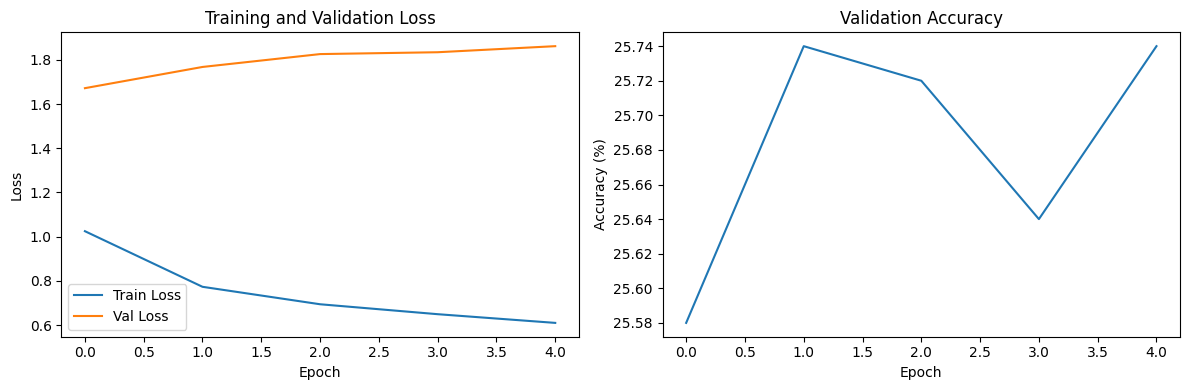


Collected 5 epochs of embeddings for visualization


In [15]:
model = CLIP(config)

# Create trainer
trainer = CLIPTrainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=1e-5,
    weight_decay=0.01
)


train_losses, val_losses, val_accuracies, epoch_img_embeds, epoch_txt_embeds, epoch_val_labels = trainer.train(
    epochs=5,
    save_path='clip_imagenet100.pt',
    collect_embeddings_for_viz=True,
    max_viz_samples=1000  # Collect only 1000 samples for visualization
)

# Plot training and validation loss, and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

print(f"\nCollected {len(epoch_img_embeds)} epochs of embeddings for visualization")

# REASON

I bealive the reason the model is not learning enough is because we have just implemented 2 Layers (Transformer Block) and 4 heads, if we have sufficient resources we can run on atleas 6-12 num_layers and 8-12 heads in each block

# Rough Implementation TO plot The Learn Space Embeddings of the Learn Embedings

Creating t-SNE projections for embedding space animation...
This may take a few minutes...
Processing epoch 1/5...
  Image embeddings shape: (1000, 512)
  Text embeddings shape: (1000, 512)
  Running t-SNE on image embeddings...
  Running t-SNE on text embeddings...
  ✓ Epoch 1 processed
Processing epoch 2/5...
  Image embeddings shape: (1000, 512)
  Text embeddings shape: (1000, 512)
  Running t-SNE on image embeddings...
  Running t-SNE on text embeddings...
  ✓ Epoch 2 processed
Processing epoch 3/5...
  Image embeddings shape: (1000, 512)
  Text embeddings shape: (1000, 512)
  Running t-SNE on image embeddings...
  Running t-SNE on text embeddings...
  ✓ Epoch 3 processed
Processing epoch 4/5...
  Image embeddings shape: (1000, 512)
  Text embeddings shape: (1000, 512)
  Running t-SNE on image embeddings...
  Running t-SNE on text embeddings...
  ✓ Epoch 4 processed
Processing epoch 5/5...
  Image embeddings shape: (1000, 512)
  Text embeddings shape: (1000, 512)
  Running t-SNE on

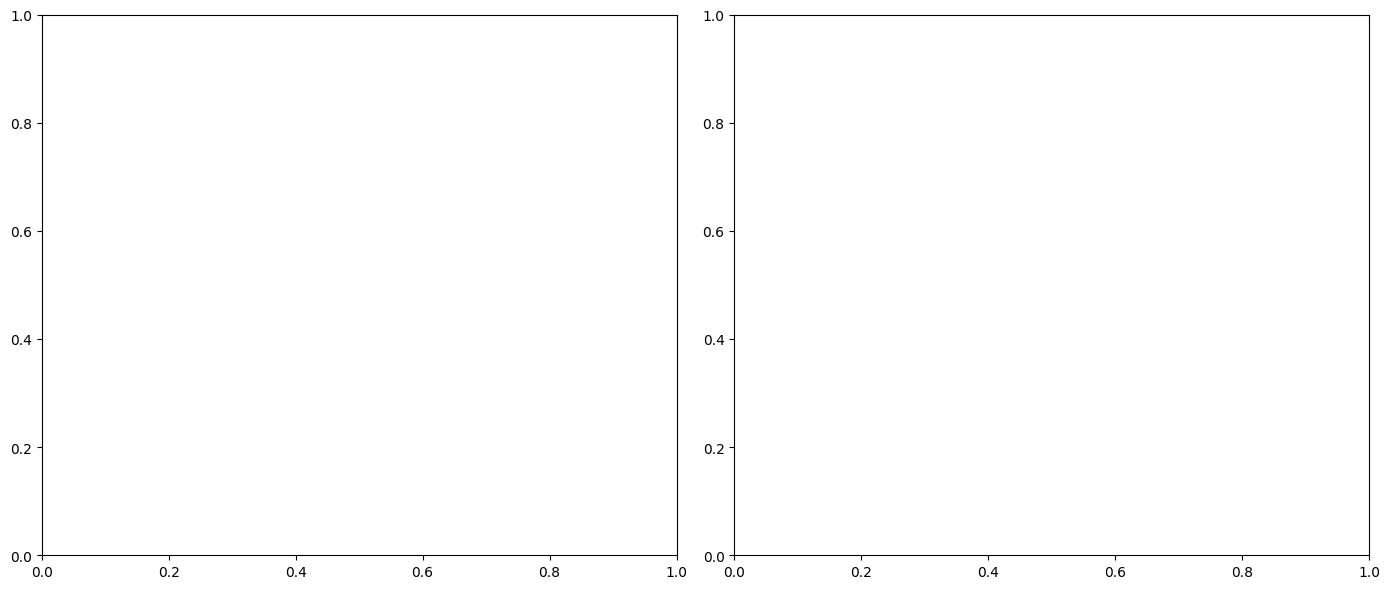


✓ Animation created successfully!
Note: The animation shows how embeddings evolve during training.
Points with the same color represent the same ImageNet100 class.
Animation saved as 'clip_imagenet100_animation.gif'


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.manifold import TSNE
from IPython.display import HTML

def safe_flatten(batches):
    """Safely concatenate batches of embeddings"""
    arrs = [x.numpy() if hasattr(x, 'numpy') else x for x in batches if x.shape[0] > 0]
    if len(arrs) == 0:
        return np.zeros((0, 512), dtype=np.float32)  # Return with correct embedding dim
    return np.concatenate(arrs, axis=0)

print("Creating t-SNE projections for embedding space animation...")
print("This may take a few minutes...")

projected_img = []
projected_txt = []
projected_labels = []
N_epochs = len(epoch_img_embeds)

for e in range(N_epochs):
    print(f"Processing epoch {e+1}/{N_epochs}...")

    # Flatten embeddings from all batches
    X_img = safe_flatten(epoch_img_embeds[e])
    X_txt = safe_flatten(epoch_txt_embeds[e])
    y = safe_flatten(epoch_val_labels[e])

    if X_img.shape[0] == 0 or X_txt.shape[0] == 0 or y.shape[0] == 0:
        print(f"  Warning: Epoch {e} has no embeddings, skipping.")
        projected_img.append(np.zeros((0, 2)))
        projected_txt.append(np.zeros((0, 2)))
        projected_labels.append(np.zeros((0,)))
        continue

    print(f"  Image embeddings shape: {X_img.shape}")
    print(f"  Text embeddings shape: {X_txt.shape}")

    # Apply t-SNE (this is the slow part)
    print(f"  Running t-SNE on image embeddings...")
    img_2d = TSNE(n_components=2, random_state=42, perplexity=min(30, X_img.shape[0]-1)).fit_transform(X_img)

    print(f"  Running t-SNE on text embeddings...")
    txt_2d = TSNE(n_components=2, random_state=42, perplexity=min(30, X_txt.shape[0]-1)).fit_transform(X_txt)

    projected_img.append(img_2d)
    projected_txt.append(txt_2d)
    projected_labels.append(y)

    print(f"  ✓ Epoch {e+1} processed")

# Find number of classes
nonempty_labels = [lbl for lbl in projected_labels if lbl.size > 0]
if nonempty_labels:
    num_classes = int(np.max([lbl.max() for lbl in nonempty_labels]) + 1)
else:
    num_classes = 100  # ImageNet100 default

print(f"\nCreating animation with {num_classes} classes...")

# Create the animation
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

def init():
    """Initialize the plot"""
    for ax in axs:
        ax.clear()
        ax.set_xlim(-50, 50)
        ax.set_ylim(-50, 50)
        ax.grid(True, alpha=0.3)
    axs[0].set_title('Image Embedding Space')
    axs[1].set_title('Text Embedding Space')
    return axs

def update(epoch):
    """Update function for animation"""
    for ax in axs:
        ax.clear()
        ax.grid(True, alpha=0.3)

    img_data = projected_img[epoch]
    txt_data = projected_txt[epoch]
    lbls = projected_labels[epoch].astype(int) if projected_labels[epoch].size > 0 else np.array([])

    if img_data.shape[0] > 0:
        scatter_img = axs[0].scatter(
            img_data[:, 0], img_data[:, 1],
            c=lbls, cmap='tab20', s=30, alpha=0.6, edgecolors='black', linewidth=0.5
        )
        axs[0].set_title(f'Image Embedding Space (Epoch {epoch+1})')
    else:
        axs[0].set_title(f'Image Embedding Space (Epoch {epoch+1}) - No Data')

    if txt_data.shape[0] > 0:
        scatter_txt = axs[1].scatter(
            txt_data[:, 0], txt_data[:, 1],
            c=lbls, cmap='tab20', s=30, alpha=0.6, edgecolors='black', linewidth=0.5
        )
        axs[1].set_title(f'Text Embedding Space (Epoch {epoch+1})')
    else:
        axs[1].set_title(f'Text Embedding Space (Epoch {epoch+1}) - No Data')

    # Set consistent axis limits
    for ax in axs:
        ax.set_xlim(-50, 50)
        ax.set_ylim(-50, 50)
        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')

    return axs

# Create animation
print("Generating animation...")
ani = FuncAnimation(fig, update, frames=N_epochs, init_func=init, blit=False, interval=1000, repeat=True)

plt.tight_layout()
plt.show()

# Display animation in notebook (for Colab/Jupyter)
try:
    display(HTML(ani.to_jshtml()))
except:
    plt.show()

print("\n✓ Animation created successfully!")
print("Note: The animation shows how embeddings evolve during training.")
print("Points with the same color represent the same ImageNet100 class.")

# Optionally save the animation
ani.save('clip_imagenet100_animation.gif', writer='pillow', fps=1)
print("Animation saved as 'clip_imagenet100_animation.gif'")

# UTILITY FUNCTIONS

### Mini Dataset Script

In [ ]:
# """So this script is used to create a mini sample of the dataset as original dataset is too large,
#  this script will take 4 images from each class and create a mini sample of the dataset"""
# import os
# import shutil
# from pathlib import Path

# SOURCE_BASE = "/content/data/datasets/ambityga/imagenet100/versions/8"
# DEST_BASE = "/content/data/mini_sample/datasets/ambityga/imagenet100/versions/8"
# IMAGES_PER_FOLDER = 4

# def copy_sample_images(src_dir, dst_dir, num_images=4):
#     os.makedirs(dst_dir, exist_ok=True)

#     image_extensions = ('.jpg', '.jpeg', '.png', '.JPEG', '.JPG', '.PNG')
#     images = [f for f in os.listdir(src_dir)
#               if os.path.isfile(os.path.join(src_dir, f))
#               and f.lower().endswith(image_extensions)]

#     for img in images[:num_images]:
#         src_path = os.path.join(src_dir, img)
#         dst_path = os.path.join(dst_dir, img)
#         shutil.copy2(src_path, dst_path)

#     return len(images[:num_images])

# def process_dataset():
#     splits = ['train.X1', 'train.X2', 'train.X3', 'train.X4', 'val.X']

#     total_copied = 0
#     total_folders = 0

#     for split in splits:
#         split_src = os.path.join(SOURCE_BASE, split)
#         split_dst = os.path.join(DEST_BASE, split)

#         if not os.path.exists(split_src):
#             print(f"Warning: {split_src} does not exist, skipping...")
#             continue


#         class_folders = [d for d in os.listdir(split_src)
#                         if os.path.isdir(os.path.join(split_src, d))]

#         print(f"\nProcessing {split}...")
#         print(f"Found {len(class_folders)} class folders")

#         for class_name in class_folders:
#             src_class_dir = os.path.join(split_src, class_name)
#             dst_class_dir = os.path.join(split_dst, class_name)


#             num_copied = copy_sample_images(src_class_dir, dst_class_dir, IMAGES_PER_FOLDER)
#             total_copied += num_copied
#             total_folders += 1

#             if num_copied > 0:
#                 print(f"  {class_name}: copied {num_copied} images")


#     labels_src = os.path.join(SOURCE_BASE, "Labels.json")
#     if os.path.exists(labels_src):
#         labels_dst = os.path.join(DEST_BASE, "Labels.json")
#         os.makedirs(os.path.dirname(labels_dst), exist_ok=True)
#         shutil.copy2(labels_src, labels_dst)
#         print(f"\nCopied Labels.json")

#     print(f"\n{'='*50}")
#     print(f"Summary:")
#     print(f"  Total folders processed: {total_folders}")
#     print(f"  Total images copied: {total_copied}")
#     print(f"  Destination: {DEST_BASE}")
#     print(f"{'='*50}")

# if __name__ == "__main__":
#     print("Creating mini-sample dataset...")
#     print(f"Source: {SOURCE_BASE}")
#     print(f"Destination: {DEST_BASE}")
#     print(f"Images per folder: {IMAGES_PER_FOLDER}")

#     process_dataset()

#     print("\nDone! You can verify with:")
#     print(f"tree -L 7 {DEST_BASE}")
